##### Implementation of ViT From Scratch With Pytorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tensorflow.python.autograph.impl.api import do_not_convert

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

'cuda'

In [4]:
#Implementation of the custom patch embedding
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, embed_dim, patch_size):
        super(PatchEmbedding, self).__init__()
        self.conv2d = nn.Conv2d(
            embed_dim, in_channels, kernel_size=patch_size, stride=patch_size
        )

    def forward(self, x):
        x = self.conv2d(x)
        x = x.flatten(start_dim=2)
        return x.transpose(1, 2)

In [5]:
class ViT(nn.Module):
    def __init__(self,img_size, patch_size = 16, in_channels = 3, num_classes = 1000, embed_dim = 768, depth = 12, n_head = 12, ff_dim = 3072, dropout = 0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(embed_dim, in_channels, patch_size)
        cls_init = torch.randn(1, 1, embed_dim) * 0.02
        self.cls_token = nn.Parameter(cls_init)
        num_patches = (img_size // patch_size) ** 2
        pos_init = torch.randn(1, num_patches + 1, embed_dim) * 0.02
        self.pos_embed = nn.Parameter(pos_init)
        self.dropout = nn.Dropout(dropout)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_head, dim_feedforward=ff_dim, dropout=dropout,  activation="gelu", batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.layernorm = nn.LayerNorm(embed_dim)
        self.output = nn.Linear(embed_dim, num_classes)


    def forward(self, x):
        z = self.patch_embed(x)
        cls_expd = self.cls_token.expand(z.shape[0], -1, -1)
        z = torch.cat((cls_expd, z), dim=1)
        z = z + self.pos_embed
        z = self.dropout(z)
        z = self.encoder(z)
        z = self.layernorm(z[:, 0])
        logits = self.output(z)
        return logits


In [6]:
vit_model = ViT(
    img_size = 224,
    patch_size = 16,
    in_channels = 3,
    num_classes = 1000,
    embed_dim = 768,
    depth = 12,
    n_head = 12,
    ff_dim = 3072,
    dropout = 0.1,
)
batch = torch.randn(4, 3, 224, 224)
logits = vit_model(batch)

In [8]:
logits.shape

torch.Size([4, 1000])

##### Fine Tuning a pretrained ViT

In [10]:
#Importing pet dataset
from datasets import load_dataset
pets = load_dataset('timm/oxford-iiit-pet')

README.md: 0.00B [00:00, ?B/s]

C:\Users\modam\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\modam\.cache\huggingface\hub\datasets--timm--oxford-iiit-pet. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


data/train-00000-of-00001.parquet:   0%|          | 0.00/378M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3680 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3669 [00:00<?, ? examples/s]

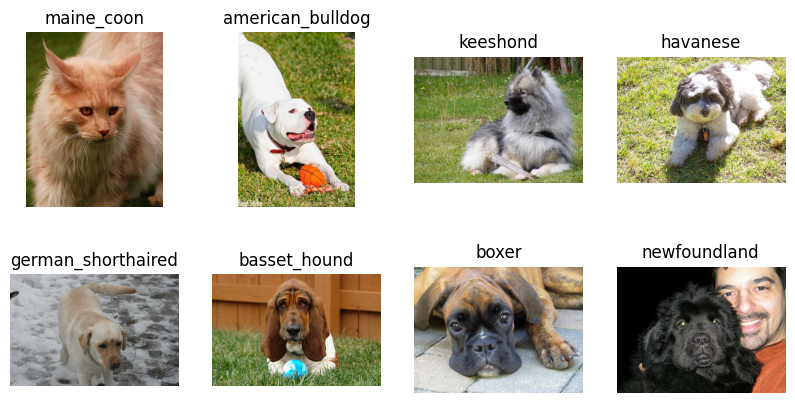

In [12]:
import matplotlib.pyplot as plt
num_rows, num_col = 2, 4
plt.figure(figsize=( num_col * 2.5, num_rows * 2.5))
class_names = pets['train'].features['label'].names
for i in range(num_rows * num_col):
    plt.subplot(num_rows, num_col, i + 1)
    example = pets['train'][i]
    plt.imshow(example['image'])
    plt.title(class_names[example['label']])
    plt.axis('off')

In [14]:
from transformers import ViTForImageClassification, AutoImageProcessor

model_id = 'google/vit-base-patch16-224-in21k'
vit_model = ViTForImageClassification.from_pretrained(model_id, num_labels=37)
vit_processor = AutoImageProcessor.from_pretrained(model_id, use_fast=True)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
vit_processor

ViTImageProcessorFast {
  "crop_size": null,
  "data_format": "channels_first",
  "default_to_square": true,
  "device": null,
  "disable_grouping": null,
  "do_center_crop": null,
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_pad": null,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "input_data_format": null,
  "pad_size": null,
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "return_tensors": null,
  "size": {
    "height": 224,
    "width": 224
  }
}

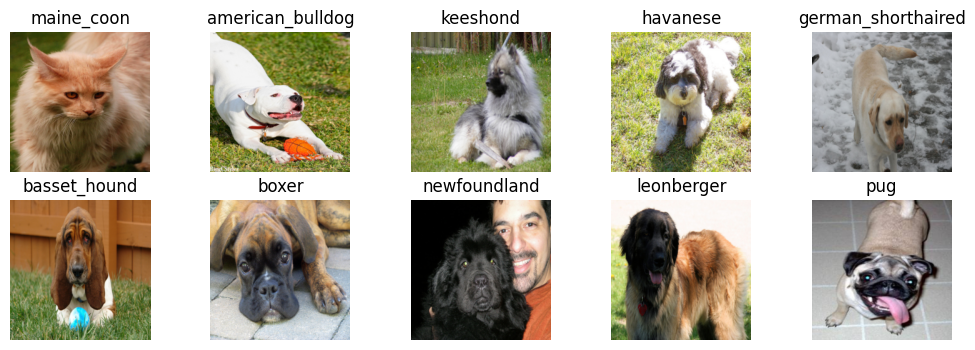

In [16]:
num_rows, num_cols = 2, 5
plt.figure(figsize=(num_cols * 2.5, num_rows * 2))
class_names = pets["train"].features["label"].names
for i in range(num_rows * num_cols):
    plt.subplot(num_rows, num_cols, i + 1)
    example = pets["train"][i]
    preprocessed = vit_processor(example["image"])["pixel_values"][0]
    plt.imshow((preprocessed.permute(1, 2, 0) + 1.) / 2.)
    plt.title(class_names[example["label"]])
    plt.axis("off")

In [17]:
vit_model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [18]:
def vit_collate_fn(batch):
    images = [example['image'] for example in batch]
    labels = [example['label'] for example in batch]
    inputs = vit_processor(images, return_tensors="pt", do_convert_rgb = True)
    inputs['labels'] = torch.tensor(labels)
    return inputs

In [20]:
from transformers import Trainer, TrainingArguments

args = TrainingArguments(
    'my_pets_vit', per_device_train_batch_size= 16, per_device_eval_batch_size= 16,eval_strategy='epoch', num_train_epochs=3, remove_unused_columns=False
)
trainer = Trainer(model = vit_model, args=args, data_collator= vit_collate_fn, train_dataset= pets['train'], eval_dataset= pets['test'])
train_output = Trainer.train(self= trainer)

comet_ml is installed but the Comet API Key is not configured. Please set the `COMET_API_KEY` environment variable to enable Comet logging. Check out the documentation for other ways of configuring it: https://www.comet.com/docs/v2/guides/experiment-management/configure-sdk/#set-the-api-key


Epoch,Training Loss,Validation Loss
1,No log,2.008865
2,No log,1.350801
3,2.030100,1.161619


In [22]:
vit_processor.save_pretrained("my_pets_vit")

['my_pets_vit\\preprocessor_config.json']

In [23]:
from PIL import Image
processor_pred = AutoImageProcessor.from_pretrained('my_pets_vit')

def predict_pet(image_path, model, processor, label_names):
    image = Image.open(image_path).convert('RGB')
    inputs = processor(image, return_tensors="pt", do_convert_rgb = True)

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

        probs = F.softmax(logits, dim=1)
        conf, pred_class = torch.max(probs, dim=1)

    label = label_names[pred_class.item()]
    confidence = conf.item()
    return label, confidence

In [24]:

labels = pets['train'].features['label'].names
img_path = 'img.png'
label, conf = predict_pet(img_path, vit_model, processor_pred, labels)

print(f"Prediction: {label} ({conf*100:.2f}% confidence)")


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor